In [371]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

In [3]:
urls={'Premier League': 'https://fbref.com/en/comps/9/history/Premier-League-Seasons',
    'La Liga': 'https://fbref.com/en/comps/12/history/La-Liga-Seasons',
    'Serie A': 'https://fbref.com/en/comps/11/history/Serie-A-Seasons',
    'Bundesliga': 'https://fbref.com/en/comps/20/history/Bundesliga-Seasons',
    'Ligue 1': 'https://fbref.com/en/comps/13/history/Ligue-1-Seasons'}

#Get URLS from each season via history page
def get_urls(history_url, season_number=15):
    page=requests.get(history_url)
    soup=BeautifulSoup(page.content,'html.parser')
    table=soup.find('table')
    urls=[]
    
    for row in table.find('tbody').find_all('tr'):
        first_cell=row.find('th')
        if first_cell and first_cell.find('a'):
            link=first_cell.find('a')['href']
            full_link='https://fbref.com'+link
            urls.append(full_link)
    
    return urls[:season_number]

#Initialise list
all_data=[]

#Starts from most recent season in order to later count down
starting_year=2025

for league, history_url in urls.items():
    print(f"\n Webscraping {league}")
    
    urls=get_urls(history_url)
    year=starting_year
    
    for season_url in urls:
        try:
            tables=pd.read_html(season_url)
            league_table=tables[0]
            time.sleep(random.randint(4, 8))

            #Organise table
            league_table2=league_table[['Rk', 'Squad', 'Pts', 'MP', 'Pts/MP',
                                        'W', 'D', 'L']]
            league_table2.columns=['Position', 'Team', 'Points', 
                                    'Matches Played', 'Points per Match',
                                   'Wins', 'Draws', 'Losses']
            league_table2=league_table2.dropna()

            #Create league table and season year
            league_table2['League']=league
            league_table2['Season']=year

            #Format columns
            league_table2=league_table2[['League', 'Season', 'Position',
                                         'Team', 'Points', 'Matches Played', 
                                         'Points per Match', 'Wins', 'Draws', 'Losses']]

            all_data.append(league_table2)

            print(f"Scraped {league} {year}")
            #Count down the seasons
            year-=1 
        
        except Exception as e:
            print(f"Error in {league} {year}: {e}")


#Put into one dataframe
combined_df=pd.concat(all_data, ignore_index=True)

#Create CSV
combined_df.to_csv('data.csv', index=False)

print("\n Data saved")


 webscraping Premier League
Scraped Premier League 2025
Scraped Premier League 2024
Scraped Premier League 2023
Scraped Premier League 2022
Scraped Premier League 2021
Scraped Premier League 2020
Scraped Premier League 2019
Scraped Premier League 2018
Scraped Premier League 2017
Scraped Premier League 2016
Scraped Premier League 2015
Scraped Premier League 2014
Scraped Premier League 2013
Scraped Premier League 2012
Scraped Premier League 2011

 webscraping La Liga
Scraped La Liga 2025
Scraped La Liga 2024
Scraped La Liga 2023
Scraped La Liga 2022
Scraped La Liga 2021
Scraped La Liga 2020
Scraped La Liga 2019
Scraped La Liga 2018
Scraped La Liga 2017
Scraped La Liga 2016
Scraped La Liga 2015
Scraped La Liga 2014
Scraped La Liga 2013
Scraped La Liga 2012
Scraped La Liga 2011

 webscraping Serie A
Scraped Serie A 2025
Scraped Serie A 2024
Scraped Serie A 2023
Scraped Serie A 2022
Scraped Serie A 2021
Scraped Serie A 2020
Scraped Serie A 2019
Scraped Serie A 2018
Scraped Serie A 2017
Scr

In [340]:
df=pd.read_csv('data.csv')
df.head(1500)

,League,Season,Position,Team,Points,Matches Played,Points per Match,Wins,Draws,Losses
0,Premier League,2025,1,Liverpool,79,33,2.39,24,7,2
1,Premier League,2025,2,Arsenal,67,34,1.97,18,13,3
2,Premier League,2025,3,Newcastle Utd,62,34,1.82,19,5,10
3,Premier League,2025,4,Manchester City,61,34,1.79,18,7,9
4,Premier League,2025,5,Chelsea,60,34,1.76,17,9,8
...,...,...,...,...,...,...,...,...,...,...
1461,Ligue 1,2011,16,Brest,46,38,1.21,11,13,14
1462,Ligue 1,2011,17,Nice,46,38,1.21,11,13,14
1463,Ligue 1,2011,18,Monaco,44,38,1.16,9,17,12
1464,Ligue 1,2011,19,Lens,35,38,0.92,7,14,17


In [338]:
#Check if any data cleaning is required
print(df.isnull().sum())
print(df.duplicated().sum())
#Check types
print(df.dtypes)

League              0
Season              0
Position            0
Team                0
Points              0
Matches Played      0
Points per Match    0
Wins                0
Draws               0
Losses              0
dtype: int64
0
League               object
Season                int64
Position              int64
Team                 object
Points                int64
Matches Played        int64
Points per Match    float64
Wins                  int64
Draws                 int64
Losses                int64
dtype: object


In [369]:
#Calculate (38/matches played) so the winning margin can be standardised
games_ratio=df.groupby('League')['Matches Played'].mean().reset_index()
games_ratio['Match Ratio']=38/games_ratio['Matches Played']

#Initialise lists
margins=[]
contenders=[]
dominant_teams=[]

#Calculate metrics
grouped=df.groupby(['League', 'Season'])

for (league, season), group in grouped:
    #Winning margin calculation
    margin=group.iloc[0]['Points']-group.iloc[1]['Points']
    margins.append({'League': league, 'Winning Margin': margin})
    
    #Title contenders calculation
    group_sorted=group.sort_values('Position')
    top_points=group_sorted.iloc[0]['Points']
    contender_count=(group_sorted['Points']>=top_points-3).sum()
    contenders.append({'League': league, 'Season': season, 
                       'Contenders': contender_count})

    #Proportion of titles won by dominant team
    if group_sorted.iloc[0]['Position']==1:
        dominant_teams.append({'League': league,
                               'Team': group_sorted.iloc[0]['Team']})

#Create data frames
margins_df=pd.DataFrame(margins)
contenders_df=pd.DataFrame(contenders)
dominant_team_df=pd.DataFrame(dominant_teams)

#Calculate averages across seasons
avg_margin=margins_df.groupby('League')['Winning Margin'].mean().reset_index()
avg_contenders=contenders_df.groupby('League')['Contenders'].mean().reset_index()

#Title count of most dominant team in each league
title_counts=dominant_team_df.groupby(['League',
                                       'Team']).size().reset_index(name='Titles')

#Identify most dominant team
dominant_team=title_counts.sort_values(['League', 'Titles']
                                ,ascending=[True, False]).drop_duplicates('League')
dominant_team['Dominance Ratio']=dominant_team['Titles']/15
dominance_ratio=dominant_team[['League', 'Dominance Ratio']].copy()

#Normalize all variables using the same function to avoid redundancy
def normalise(df,column):
    min_val=df[column].min()
    max_val=df[column].max()
    df[f'Normalised {column}']=(df[column]-min_val)/(max_val-min_val)
    return df

#Normalise all metrics
avg_margin=normalise(avg_margin, 'Winning Margin')
avg_contenders=normalise(avg_contenders, 'Contenders')
avg_contenders['Normalised Title Contenders']=1-avg_contenders['Normalised Contenders']
dominance_ratio=normalise(dominance_ratio, 'Dominance Ratio')

#Merge all normalised data
merged = avg_contenders[['League', 'Normalised Title Contenders']]\
    .merge(dominance_ratio[['League', 'Normalised Dominance Ratio']], on='League')\
    .merge(avg_margin[['League', 'Normalised Winning Margin']], on='League')\
    .merge(games_ratio[['League', 'Match Ratio']], on='League')

#Calculate Competitiveness Score
competitive_title = (0.25*merged['Normalised Title Contenders']) + \
                    (0.5*merged['Normalised Dominance Ratio']) + \
                    (0.25*merged['Normalised Winning Margin']) * \
                    merged['Match Ratio']

#Rename columns to match exact style
merged2=merged.copy()
merged2.rename(columns={
    'Normalised Title Contenders': 'Average amount of contenders for league title per season (Normalised)',
    'Normalised Dominance Ratio': 'Proportion of total titles won by the most dominant team in each league (Normalised)',
    'Normalised Winning Margin' : 'Average winning margin in each league (Normalised)',
    'Match Ratio': 'Matches per season (Normalised)'}, inplace=True)

#Add competitiveness score to the dataframe
merged2['League title competitiveness score']=competitive_title

#Final print statement
print('Each variable is normalised such that 0=the least competitive team in a given metric across all leagues and 1=the most competitive.')
merged2


Each variable is normalised such that 0=the least competitive team in a given metric across all leagues and 1=the most competitive.


,League,Average amount of contenders for league title per season (Normalised),Proportion of total titles won by the most dominant team in each league (Normalised),Average winning margin in each league (Normalised),Matches per season (Normalised),League title competitiveness score
0,Bundesliga,1.0,1.00,1.000000,1.124753,1.031188
1,La Liga,0.0,0.00,0.000000,1.009028,0.000000
2,Ligue 1,0.8,0.75,0.900000,1.038021,0.808555
3,Premier League,0.4,0.00,0.157143,1.007601,0.139584
4,Serie A,0.8,0.25,0.357143,1.008850,0.415076


In [370]:
#Get data from merged
labels=['Normalised Title Contenders', 'Normalised Dominance Ratio'
        , 'Normalised Winning Margin']
fig=go.Figure()

#Plot each league
for i, row in merged.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[labels].tolist()+[row[labels].iloc[0]],theta=labels+[labels[0]], 
        fill='toself', 
        name=row['League']))

fig.update_layout(title="League's Performance Across Title Competitiveness Metrics",
    template='plotly_dark')

fig.show()


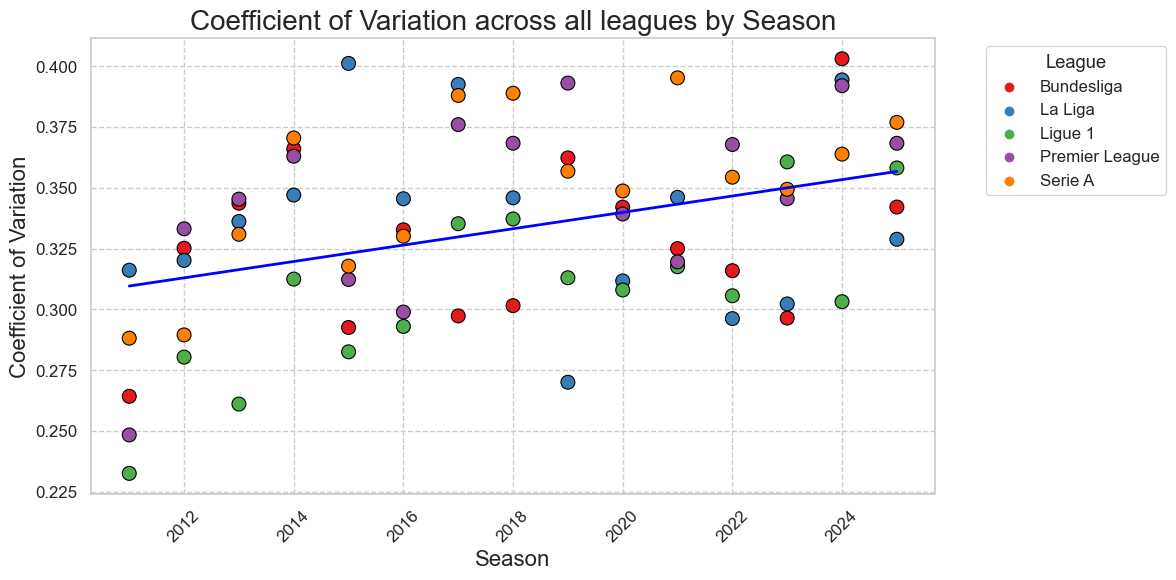

In [298]:
#Get Mean and SD ready for calculating CV
cv_df=df.groupby(['League', 'Season']).agg(
    Mean_Points=('Points', 'mean'),
    Std_Points=('Points', 'std')).reset_index()

#Calculate CV
cv_df['CV']=cv_df['Std_Points']/cv_df['Mean_Points']

#Plot CV
plt.figure(figsize=(12, 6))

#Line of best fit, using robust to minimise impact of outliers
sns.regplot(data=cv_df, x='Season', y='CV',
            line_kws={'color': 'blue', 'linewidth': 2}, robust=True, ci=False)

#Add scatterplot showing CV for each league and season
sns.scatterplot(data=cv_df, x='Season', y='CV',
                hue='League', palette='Set1', s=100, edgecolor='black')

#Label
plt.title('Coefficient of Variation across all leagues by Season', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Coefficient of Variation', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')

#For neatness
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()


In [394]:
fig=go.Figure()

#Scatter plot for CV by league and season
for league in cv_df['League'].unique():
    league_data=cv_df[cv_df['League']==league]
    fig.add_trace(go.Scatter(x=league_data['Season'], y=league_data['CV'],
        mode='markers',name=league))

#Add line of best fit
slope, intercept=stats.linregress(cv_df['Season'], cv_df['CV'])[:2]

fig.add_trace(go.Scatter(x=cv_df['Season'], y=y_fit, mode='lines',
                         name='Line of best fit'))

# Layout customization
fig.update_layout(title='Coefficient of Variation across all leagues by Season',
    xaxis_title='Season',
    yaxis_title='Coefficient of Variation',
    xaxis=dict(tickangle=45),
    legend_title='League',
    template='plotly_dark')

fig.show()

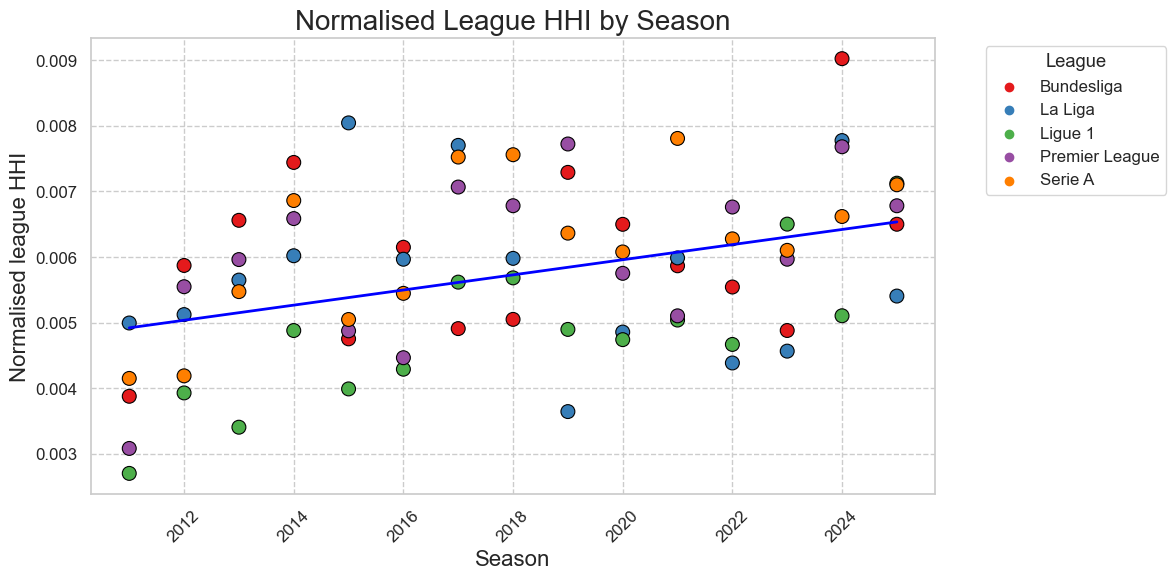

In [299]:
#Get total points per league and season
df['Total Points']=df.groupby(['League', 'Season'])['Points'].transform('sum')

#Calculate HHI
#Create new columns necessary for calculation
df['Points Share']=df['Points']/df['Total Points']
df['Points Share Squared']=df['Points Share']**2

#Sum points
hhi_df=df.groupby(['League', 'Season'])['Points Share Squared'].sum().reset_index()
hhi_df.rename(columns={'Points Share Squared': 'HHI'}, inplace=True)

#Normalise HHI for number of teams in a league
#Get Number of teams per league and season
team_count=df.groupby(['League', 'Season'])['Team'].nunique().reset_index()
team_count.rename(columns={'Team': 'Number of Teams'}, inplace=True)

#Merge HHI with team count
hhi_df = hhi_df.merge(team_count, on=['League', 'Season'])

#Get normalised HHI
hhi_df['HHI Normalised']=(hhi_df['HHI']-1/
                          hhi_df['Number of Teams'])/(1-1/hhi_df['Number of Teams'])
#Plot HHI
plt.figure(figsize=(12, 6))

#Plot line of best fit, using robust to reduce effect of outliers
sns.regplot(data=hhi_df, x='Season', y='HHI Normalised',
            line_kws={'color': 'blue', 'linewidth': 2},
            robust=True, ci=False)

#Add scatter plot
sns.scatterplot(data=hhi_df, x='Season', y='HHI Normalised',
                hue='League', palette='Set1', s=100, edgecolor='black')

#Label
plt.title('Normalised League HHI by Season'
          , fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Normalised league HHI', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='League', bbox_to_anchor=(1.05, 1))

#For neatness
plt.grid(True, linestyle='--')
plt.tight_layout()

plt.show()


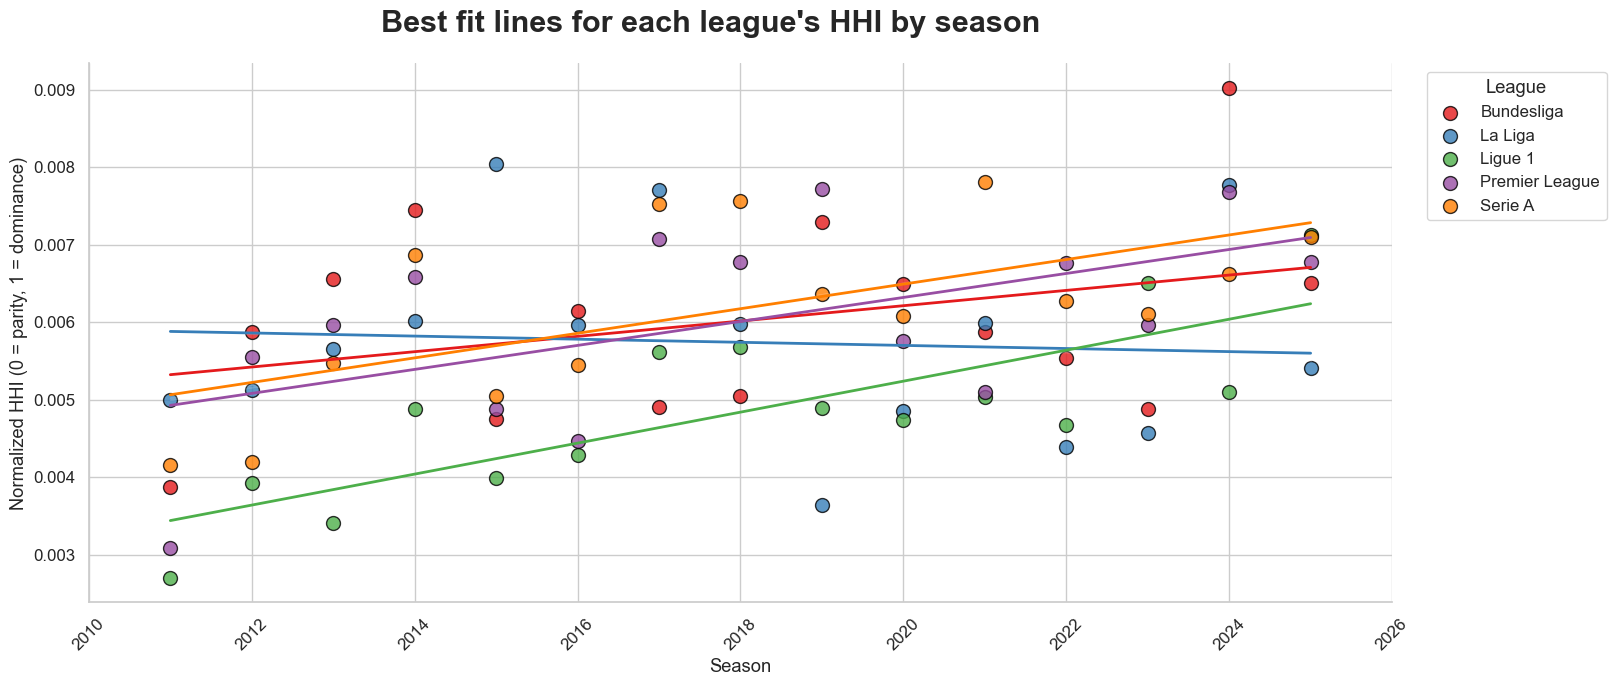

In [216]:
#Plot line of best fit for each league's HHI
#lm plot to allow for hue
g=sns.lmplot(data=hhi_df, x='Season', y='HHI Normalised', hue='League', height=7,
    aspect=1.8, palette='Set1', scatter_kws={'s': 100, 'edgecolor': 'black'},
    line_kws={'linewidth': 2}, ci=False)

#Label
g.fig.suptitle("Best fit lines for each league's HHI by season",
               fontsize=22, weight='bold')
g.set_axis_labels('Season', 'Normalised HHI)')
g.set_xticklabels(rotation=45)

plt.tight_layout()
g._legend.remove()
plt.legend(title='League', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()
